<a href="https://www.kaggle.com/code/vanpatangan/predict-podcast-listening-time?scriptVersionId=233772421" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read in data
train = pd.read_csv("/kaggle/input/playground-series-s5e4/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e4/test.csv")

# EDA

In [3]:
def check(df):
    """
    Generates a concise summary of DataFrame columns.
    """
    # Use list comprehension to iterate over each column
    summary = [
        [col, df[col].dtype, df[col].count(), df[col].nunique(), df[col].isnull().sum(), df.duplicated().sum()]
        for col in df.columns
    ]

    # Create a DataFrame from the list of lists
    df_check = pd.DataFrame(summary, columns=["column", "dtype", "instances", "unique", "sum_null", "duplicates"])

    return df_check

In [4]:
print("Training Data Summary")
display(check(train))
display(train.head())

print("Test Data Summary")
display(check(test))
display(test.head())

Training Data Summary


,column,dtype,instances,unique,sum_null,duplicates
0,id,int64,750000,750000,0,0
1,Podcast_Name,object,750000,48,0,0
2,Episode_Title,object,750000,100,0,0
3,Episode_Length_minutes,float64,662907,12268,87093,0
4,Genre,object,750000,10,0,0
5,Host_Popularity_percentage,float64,750000,8038,0,0
6,Publication_Day,object,750000,7,0,0
7,Publication_Time,object,750000,4,0,0
8,Guest_Popularity_percentage,float64,603970,10019,146030,0
9,Number_of_Ads,float64,749999,12,1,0


,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


Test Data Summary


,column,dtype,instances,unique,sum_null,duplicates
0,id,int64,250000,250000,0,0
1,Podcast_Name,object,250000,48,0,0
2,Episode_Title,object,250000,100,0,0
3,Episode_Length_minutes,float64,221264,11631,28736,0
4,Genre,object,250000,10,0,0
5,Host_Popularity_percentage,float64,250000,8010,0,0
6,Publication_Day,object,250000,7,0,0
7,Publication_Time,object,250000,4,0,0
8,Guest_Popularity_percentage,float64,201168,9961,48832,0
9,Number_of_Ads,float64,250000,6,0,0


,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


## Visualizations

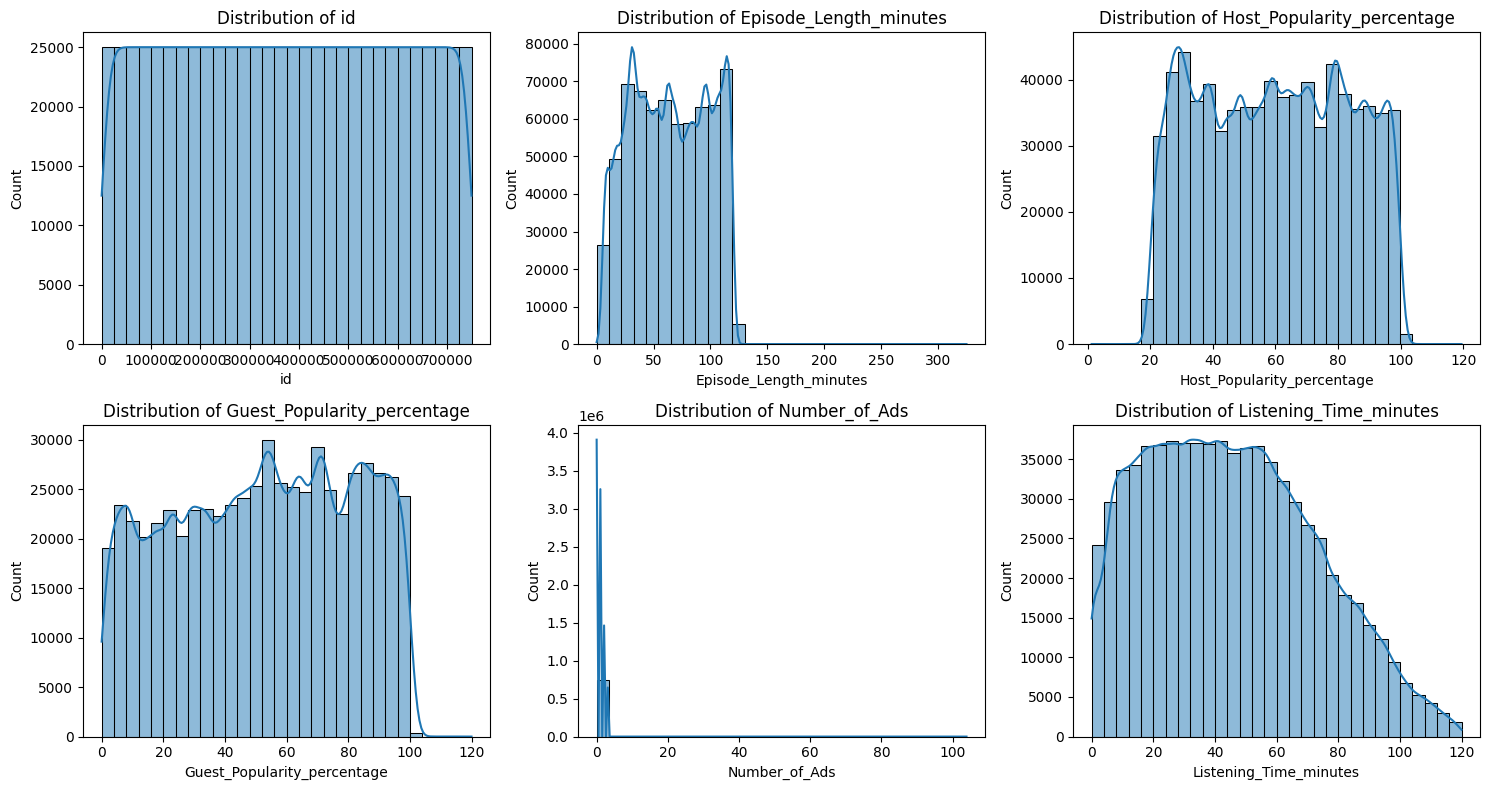

In [5]:
# Select only numeric columns
numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns

# Set the number of plots per row/column
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

# Set figure size
plt.figure(figsize=(5 * n_cols, 4 * n_rows))

# Plot each numeric column
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(train[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

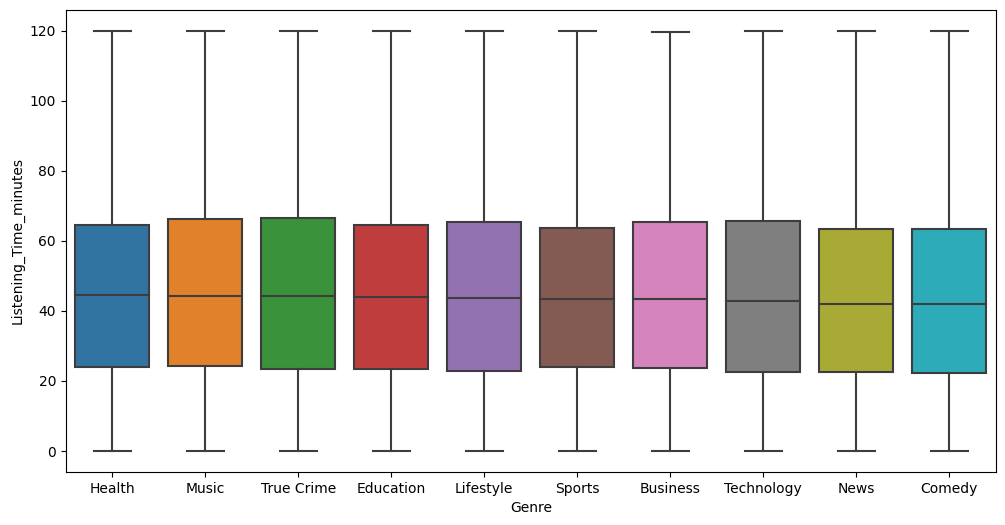

In [6]:
# Listening_Time_minutes across different Genre categories
plt.figure(figsize=(12, 6))
genre_order = train.groupby('Genre')['Listening_Time_minutes'].median().sort_values(ascending=False).index
sns.boxplot(data=train, x='Genre', y='Listening_Time_minutes', order=genre_order)
plt.show()

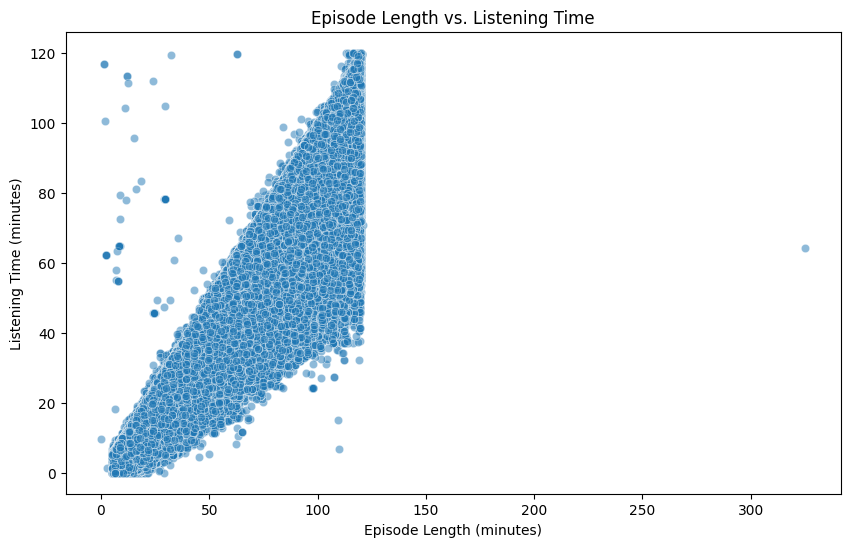

In [7]:
# Episode Length vs. Listening Time
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train, x='Episode_Length_minutes', y='Listening_Time_minutes', alpha=0.5)
plt.title('Episode Length vs. Listening Time')
plt.xlabel('Episode Length (minutes)')
plt.ylabel('Listening Time (minutes)')
plt.show()

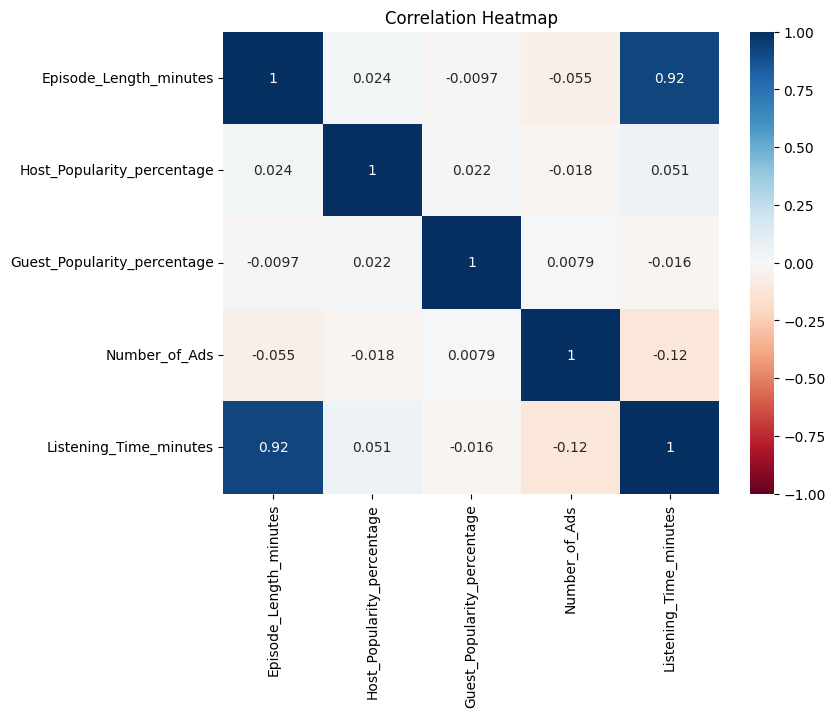

In [8]:
# Correlation Matrix of Numerical Features
plt.figure(figsize=(8, 6))
sns.heatmap(train[['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Listening_Time_minutes']].corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

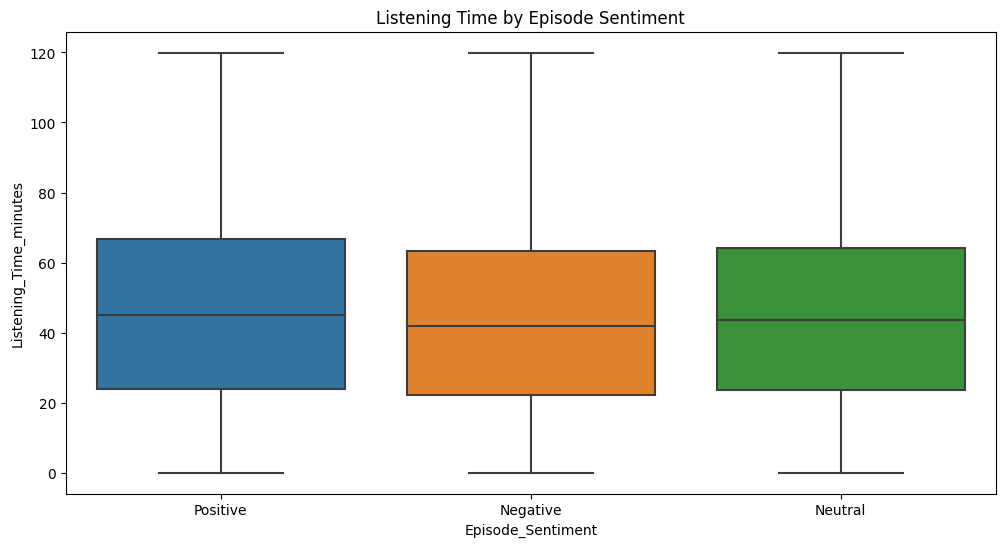

In [9]:
# Listening Time by Episode Sentiment
plt.figure(figsize=(12, 6))
sns.boxplot(data=train, x='Episode_Sentiment', y='Listening_Time_minutes')
plt.title('Listening Time by Episode Sentiment')
plt.show()

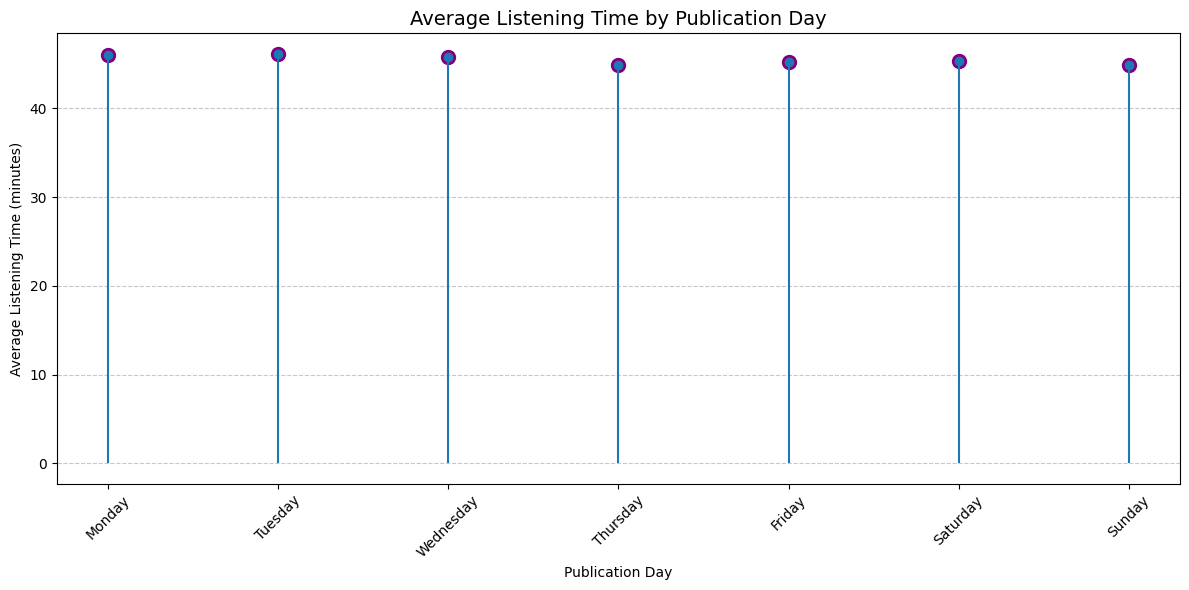

In [10]:
# Compute the average listening time per day
avg_listening = train.groupby('Publication_Day')['Listening_Time_minutes'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

# Create the lollipop chart
plt.figure(figsize=(12, 6))
plt.stem(avg_listening.index, avg_listening.values, basefmt=" ", use_line_collection=True)
plt.scatter(avg_listening.index, avg_listening.values, color='purple', s=100)

# Style
plt.title('Average Listening Time by Publication Day', fontsize=14)
plt.xlabel('Publication Day')
plt.ylabel('Average Listening Time (minutes)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Preprocess

In [11]:
from sklearn.impute import SimpleImputer

# Define numerical columns with missing values
num_cols = ['Episode_Length_minutes', 'Guest_Popularity_percentage', 'Number_of_Ads']

# Imputer (fit on train, apply to both)
imputer = SimpleImputer(strategy='median')
train[num_cols] = imputer.fit_transform(train[num_cols])
test[num_cols] = imputer.transform(test[num_cols]) # Use train's median

In [12]:
# Convert Publication_Time to numerical bins 
time_mapping = {
    'Night': 0,
    'Morning': 6,
    'Afternoon': 12,
    'Evening': 18
}

train['Publication_Hour'] = train['Publication_Time'].map(time_mapping)
test['Publication_Hour'] = test['Publication_Time'].map(time_mapping)

# Drop original column
train.drop('Publication_Time', axis=1, inplace=True)
test.drop('Publication_Time', axis=1, inplace=True)

## Interaction Features

In [13]:
# Episode Length / Popularity
train['Length_Host_Popularity'] = train['Episode_Length_minutes'] * train['Host_Popularity_percentage']
test['Length_Host_Popularity'] = test['Episode_Length_minutes'] * test['Host_Popularity_percentage']
train['Length_Guest_Popularity'] = train['Episode_Length_minutes'] * train['Guest_Popularity_percentage']
test['Length_Guest_Popularity'] = test['Episode_Length_minutes'] * test['Guest_Popularity_percentage']

# Ads / Episode Length 
train['Ads_Length_Ratio'] = train['Number_of_Ads'] / (train['Episode_Length_minutes'] + 1e-6)  
test['Ads_Length_Ratio'] = test['Number_of_Ads'] / (test['Episode_Length_minutes'] + 1e-6)

In [15]:
# Encode categorical variables 

# Target encoding for high cardinality columns (Too many unique values for one hot encoding)
for col in ['Podcast_Name', 'Episode_Title']:
    mean_target = train.groupby(col)['Listening_Time_minutes'].mean()
    train[col + '_encoded'] = train[col].map(mean_target)
    test[col + '_encoded'] = test[col].map(mean_target).fillna(mean_target.mean())  # Fill unseen categories

# One hot encoding for low cardinality columns
cat_cols = ['Genre', 'Publication_Day', 'Episode_Sentiment']
train = pd.get_dummies(train, columns=cat_cols, drop_first=True)
test = pd.get_dummies(test, columns=cat_cols, drop_first=True)

# Align train and test columns (in case of mismatched categories)
train, test = train.align(test, join='left', axis=1, fill_value=0)

# Drop unnecessary columns
test_id = test['id'].copy() # For submission later
columns_to_drop = ['Podcast_Name','Episode_Title', 'id']

train.drop(columns=columns_to_drop, inplace=True)
test.drop(columns=columns_to_drop, inplace=True)

In [16]:
# Popularity Ratio / Sentiment
train['Host_Popularity_Sentiment_Positive'] = train['Host_Popularity_percentage'] * train.get('Episode_Sentiment_Positive', 0)
test['Host_Popularity_Sentiment_Positive'] = test['Host_Popularity_percentage'] * test.get('Episode_Sentiment_Positive', 0)

# Modeling

In [17]:
from sklearn.model_selection import train_test_split

X = train.drop(columns=['Listening_Time_minutes'])  # Features
y = train['Listening_Time_minutes']  # Target

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Initialize KFold for crossvalidation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    # Split data for this fold
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    # Define parameters
params = {
    'objective': 'regression',          # For predicting target var
    'metric': 'rmse',                   # Root Mean Squared Error
    'boosting_type': 'gbdt',            # Gradient Boosted Decision Trees
    'num_leaves': 74,                   # Reduced to prevent overfitting
    'learning_rate': 0.09,              # Smaller = slower, more robust
    'feature_fraction': 0.9,            # Feature subsampling
    'bagging_freq': 7,
    'min_child_samples': 93,
    'max_depth': 8,
    'verbose': -1                       # Suppress warnings
}

# Train with early stopping using callback
model = lgb.train(
    params,
    train_data,
    num_boost_round=2000,               # Max iterations
    valid_sets=[val_data],              # Validation set for monitoring
    valid_names=['validation'],         # Name for validation set in output
    callbacks=[
        lgb.early_stopping(stopping_rounds=100), # Stop if no improvement for 100 rounds
        lgb.log_evaluation(period=10)            # Print progress every 10 rounds
    ]
)

 # Predict and calculate RMSE
y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
rmse_scores.append(rmse)
    
print(f"Fold {fold} RMSE: {rmse:.4f}")
print(f"Fold {fold} Best Iteration: {model.best_iteration}\n")

 # Cross validated performance
print(f"Average Validation RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")


Training until validation scores don't improve for 100 rounds
[10]	validation's rmse: 16.1302
[20]	validation's rmse: 13.6278
[30]	validation's rmse: 13.1839
[40]	validation's rmse: 13.0954
[50]	validation's rmse: 13.0682
[60]	validation's rmse: 13.0557
[70]	validation's rmse: 13.045
[80]	validation's rmse: 13.0391
[90]	validation's rmse: 13.0332
[100]	validation's rmse: 13.0284
[110]	validation's rmse: 13.0231
[120]	validation's rmse: 13.0186
[130]	validation's rmse: 13.0149
[140]	validation's rmse: 13.0121
[150]	validation's rmse: 13.0074
[160]	validation's rmse: 13.003
[170]	validation's rmse: 12.9993
[180]	validation's rmse: 12.9954
[190]	validation's rmse: 12.9925
[200]	validation's rmse: 12.9896
[210]	validation's rmse: 12.9854
[220]	validation's rmse: 12.9825
[230]	validation's rmse: 12.9802
[240]	validation's rmse: 12.9784
[250]	validation's rmse: 12.9764
[260]	validation's rmse: 12.9734
[270]	validation's rmse: 12.9711
[280]	validation's rmse: 12.9689
[290]	validation's rmse: 

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

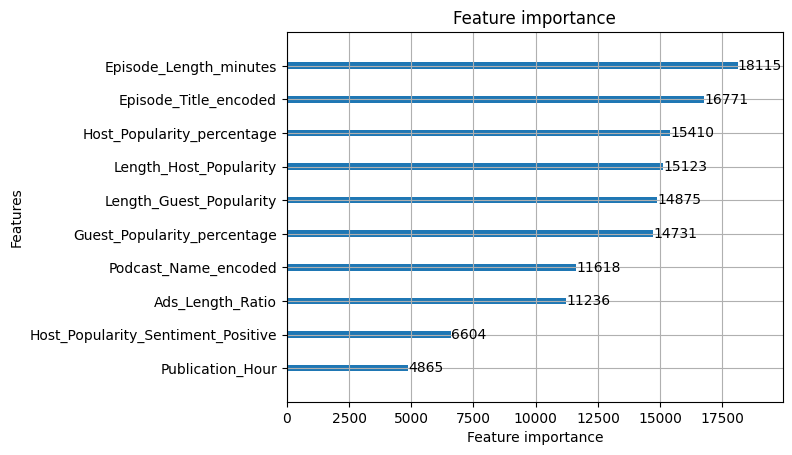

In [20]:
lgb.plot_importance(model, max_num_features=10)

## Final Prediction

In [22]:
# Align columns
X_val = X_val[X_train.columns]
test = test[X_train.columns]

# Predict on test set
test_pred = model.predict(test, num_iteration=model.best_iteration)

# Submission

In [23]:
# Create submission
submission = pd.DataFrame({'id': test_id, 'Listening_Time_minutes': test_pred})
submission.to_csv('submission.csv', index=False)
submission.head()

,id,Listening_Time_minutes
0,750000,51.585707
1,750001,18.776722
2,750002,50.698652
3,750003,75.241836
4,750004,45.109732
